In [1]:
import pywt
import scipy
from tqdm import tqdm
from scipy import signal
import scipy.signal
from scipy.signal import butter, iirnotch, lfilter, find_peaks, peak_prominences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ecg_wave = np.load('/smc_work/datanvme/smc/origin/smc_data_2021_210126090335_8456b08c-393c-34ed-a318-90c2e46c1130_001.npy')[:,6]

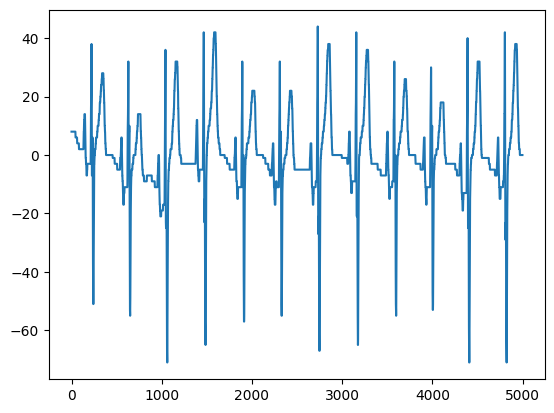

In [3]:
plt.plot(ecg_wave)
plt.show()

In [4]:
def make_windows(data, sample_rate, windowsize=120, overlap=0, min_size=20):
    '''slices data into windows

    Funcion that slices data into windows for concurrent analysis.
    Used by process_segmentwise wrapper function.

    Parameters
    ----------
    data : 1-d array
        array containing heart rate sensor data

    sample_rate : int or float
        sample rate of the data stream in 'data'

    windowsize : int
        size of the window that is sliced in seconds

    overlap : float
        fraction of overlap between two adjacent windows: 0 <= float < 1.0

    min_size : int
        the minimum size for the last (partial) window to be included. Very short windows
        might not stable for peak fitting, especially when significant noise is present.
        Slightly longer windows are likely stable but don't make much sense from a
        signal analysis perspective.

    Returns
    -------
    out : array
        tuples of window indices

    Examples
    --------
    Assuming a given example data file:

    >>> import heartpy as hp
    >>> data, _ = hp.load_exampledata(1)

    We can split the data into windows:

    >>> indices = make_windows(data, 100.0, windowsize = 30, overlap = 0.5, min_size = 20)
    >>> indices.shape
    (9, 2)

    Specifying min_size = -1 will include the last window no matter what:

    >>> indices = make_windows(data, 100.0, windowsize = 30, overlap = 0.5, min_size = -1)
    '''
    ln = len(data)
    window = windowsize * sample_rate
    stepsize = (1 - overlap) * window
    start = 0
    end = window

    slices = []
    while end < len(data):
        slices.append((start, end))
        start += stepsize
        end += stepsize

    if min_size == -1:
        slices[-1] = (slices[-1][0], len(data))
    elif (ln - start) / sample_rate >= min_size:
        slices.append((start, ln))

    return np.array(slices, dtype=np.int32)

In [6]:
make_windows(ecg_wave,5)

array([[   0,  600],
       [ 600, 1200],
       [1200, 1800],
       [1800, 2400],
       [2400, 3000],
       [3000, 3600],
       [3600, 4200],
       [4200, 4800],
       [4800, 5000]], dtype=int32)

In [7]:
from heartpy.datautils import rolling_mean

In [18]:
rol_mean = rolling_mean(ecg_wave, windowsize = 0.75, sample_rate = 500.0)

In [19]:
rol_mean

array([5.7306666, 5.7306666, 5.7306666, ..., 0.816    , 0.816    ,
       0.816    ], dtype=float32)

In [23]:
def detect_peaks(hrdata, rol_mean, ma_perc, sample_rate, update_dict=False, working_data={}):
    '''detect peaks in signal

    Function that detects heartrate peaks in the given dataset.

    Parameters
    ----------
    hr data : 1-d numpy array or list
        array or list containing the heart rate data

    rol_mean : 1-d numpy array
        array containing the rolling mean of the heart rate signal

    ma_perc : int or float
        the percentage with which to raise the rolling mean,
        used for fitting detection solutions to data

    sample_rate : int or float
        the sample rate of the provided data set

    update_dict : bool
        whether to update the peak information in the module's data structure
        Settable to False to allow this function to be re-used for example by
        the breath analysis module.
        default : True

    Examples
    --------
    Normally part of the peak detection pipeline. Given the first example data
    it would work like this:

    >>> import heartpy as hp
    >>> from heartpy.datautils import rolling_mean
    >>> data, _ = hp.load_exampledata(0)
    >>> rol_mean = rolling_mean(data, windowsize = 0.75, sample_rate = 100.0)
    >>> wd = detect_peaks(data, rol_mean, ma_perc = 20, sample_rate = 100.0)

    Now the peaklist has been appended to the working data dict. Let's look
    at the first five peak positions:

    >>> wd['peaklist'][0:5]
    array([ 63, 165, 264, 360, 460], dtype=int64)
    '''
    rmean = np.array(rol_mean)

    #rol_mean = rmean + ((rmean / 100) * ma_perc)
    mn = np.mean(rmean / 100) * ma_perc
    rol_mean = rmean + mn

    peaksx = np.where((hrdata > rol_mean))[0]
    peaksy = hrdata[peaksx]
    peakedges = np.concatenate((np.array([0]),
                                (np.where(np.diff(peaksx) > 1)[0]),
                                np.array([len(peaksx)])))
    peaklist = []

    for i in range(0, len(peakedges)-1):
        try:
            y_values = peaksy[peakedges[i]:peakedges[i+1]].tolist()
            peaklist.append(peaksx[peakedges[i] + y_values.index(max(y_values))])
        except:
            pass

    if update_dict:
        working_data['peaklist'] = peaklist
        working_data['ybeat'] = [hrdata[x] for x in peaklist]
        working_data['rolling_mean'] = rol_mean
        working_data = calc_rr(working_data['peaklist'], sample_rate,
                               working_data=working_data)
        if len(working_data['RR_list']) > 0:
            working_data['rrsd'] = np.std(working_data['RR_list'])
        else:
            working_data['rrsd'] = np.inf
        return working_data
    else:
        return peaklist, working_data

In [28]:
detect_peaks(ecg_wave,rol_mean,20,500)[0]

[0,
 143,
 221,
 224,
 338,
 551,
 629,
 737,
 783,
 964,
 1041,
 1044,
 1154,
 1388,
 1466,
 1580,
 1630,
 1893,
 1896,
 1905,
 2003,
 2052,
 2232,
 2309,
 2321,
 2421,
 2649,
 2730,
 2845,
 2887,
 3078,
 3156,
 3272,
 3501,
 3578,
 3581,
 3693,
 3906,
 3985,
 3997,
 4092,
 4144,
 4314,
 4390,
 4503,
 4727,
 4804,
 4918]

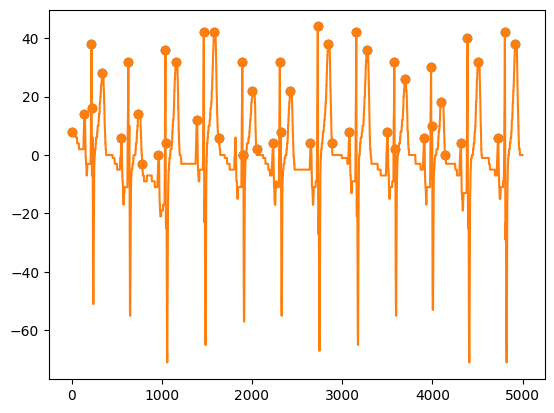

In [31]:
plt.scatter(detect_peaks(ecg_wave,rol_mean,20,500)[0],ecg_wave[detect_peaks(ecg_wave,rol_mean,20,500)[0]])
plt.plot(ecg_wave)
plt.show()

### 기울기로 찾기

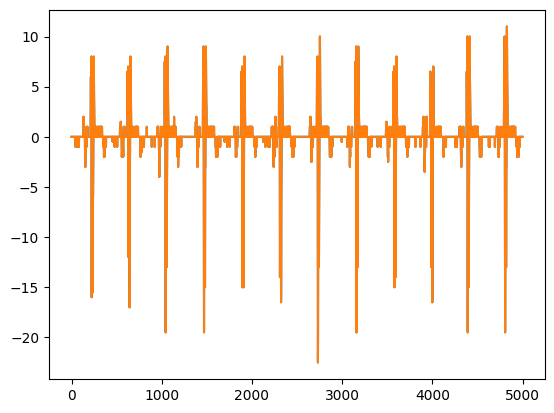

In [34]:
plt.plot(np.gradient(ecg_wave))
plt.show()